# Relation Network Keras

有點像Siamese network中"learn to compare"的概念，Relation Network使用一個embedding network為data做特徵萃取，再使用一個relation network學習依高維空間比較的函式。

Siamese只負責算出兩個類別的高維特徵關聯性，relation net則將embeded 出的高維資料間的關聯性做softmax，找出最有相關的那一個。這使得Relation net等於能平行處理多個類別比較，加快inference速度。

以500人公司做人臉識別的case來講，每個人10張照片，使用Siamese Network要比較至少500次才能完成人員的確認，或者使用500倍記憶體來達成平行化。相較之下Relation network亦可拿來做少way數的N-way-K-shot training，一次比較N組人臉，這樣既能加快比較速度也能減少記憶體消耗。
做Relation network的訓練要切分meta-training跟meta-testing classes，像是500個人臉中找出400個做為training、100個做為testing。訓練時每次從400個class中隨機挑選5個class做訓練，每個class 1張照片，其中一個class中多挑選一張作為query data。這樣挑選多次(範例用10000次)後成為一個dataset，以這個dataset做訓練，則可以使model變成一個可以適應各種5-way比較任務的model。在testing時可以從100個testing中隨機挑選五個class做K次訓練並測試，每個class一張照片中要能挑出與query image相同的照片，值得一提的是K可以是0。

在forward的時候，Relation net會先將N個class的instances(examples)還有query data做特徵萃取($f_\phi$)，並將一個instance跟query組成一個pair concatenate起來，並進到relation network($g_\phi$)，共取得N個relation score。這個score的值會再被拉到0~1之間(原作者是用sigmoid function)，做1-hot prediction。在backward方面，這個network的output型態與傳統classificaiton一樣，所以也可以使用categorical cross entropy作為loss function。

Relation network學習了如何在N個data中找到一張同樣class的data，就算是沒train過的class也可以比較。

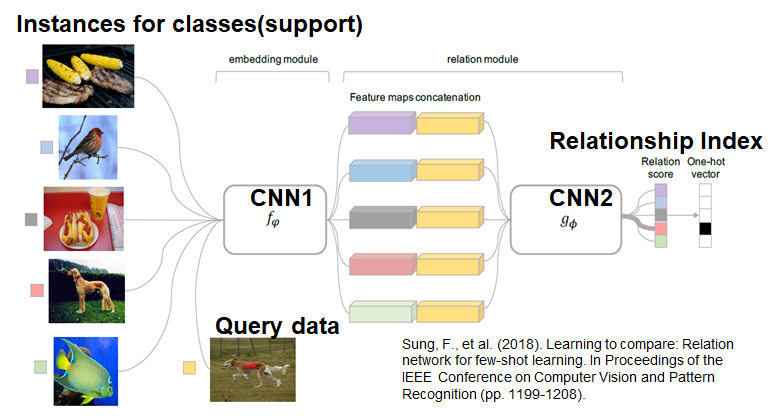

## 範例內容
這次的資料集與Siames Network範例中的資料集一樣是使用[AT & T's the Database of Faces](https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)做人臉辨識範例，40個人每人共有10張不同角度的照片。

我們這次的任務是希望network學會只依照片來辨別人臉屬於哪個人：

選出5個不同人的照片，並從這五個人的照片中再抽出一張，network必須辨識這一張屬於哪個人。

**程式碼部分會做以下部分：**
* Data Loader
* 資料抽樣、切分
* 建立模型
* 模型訓練
* 預測結果

# Data Loader
* (meta)batch: 一次訓練BATCH_SIZE個task
* task: 40人選5人不重複
* sample: 5人資料中都是10張選一張當support
，還要從剩下45張選一張query

In [38]:
# Colab上的話要下載資料
# !gdown https://drive.google.com/u/1/uc?id=1sSAsIVQl4u_eMWw4t9dfD3gGnHKwAUhz&export=download
# !unzip orl_faces.zip
# !mv orl_faces/ ..

In [39]:
'''Toolboxs'''
import re
import cv2
import os
from os.path import join
import random
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split
'''Tensorflow'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks as cb
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten,Activation,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB0

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)
if len(gpus)>1:
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{len(gpus)-1}"

先設定讀取圖片程式，這個資料集圖檔讀取方式需自訂，要輸入圖片的和寬、高、最大值，其中header是圖檔的標頭，讀取時要略過

圖片路徑為{orl_faces資料夾}/s1到s40

每個subject的圖片放在不同資料夾

In [40]:
import numpy as np
import cv2

W,H,CH = 64,64,1

def load_img(path, width = W, hight=H):
    img=cv2.imread(path.numpy().decode())[...,0].astype(np.float32)/255.
#     img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
    min_of_shape = np.min(img.shape[:2])
    oh = (img.shape[0] - min_of_shape) // 2
    ow = (img.shape[1] - min_of_shape) // 2
    center_square = np.array([width,hight])// 2
    new_size=(width,hight)
    
    # cropping + resize
    img = img[oh:oh + min_of_shape, ow:ow + min_of_shape]
    img=np.expand_dims(cv2.resize(img, new_size),-1)
    return tf.constant(img-0.5)
SUFFIX='.jpg'

In [41]:
W,H,CH = 64,64,1
'''pgm檔讀取程式'''
# def read_pgm(filename):
#     byteorder='>'
#     #first we read the image, as a raw file to the buffer
#     with open(filename, 'rb') as f:
#         buffer = f.read()
    
#     #using regex, we extract the header, width, height and maxval of the image
#     header, width, height, maxval = re.search(
#         b"(^P5\s(?:\s*#.*[\r\n])*"
#         b"(\d+)\s(?:\s*#.*[\r\n])*"
#         b"(\d+)\s(?:\s*#.*[\r\n])*"
#         b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
#     #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
#     return np.frombuffer(buffer,
#                             dtype='u1' if int(maxval) < 256 else byteorder+'u2',
#                             count=int(width)*int(height),
#                             offset=len(header)
#                             ).reshape((int(height), int(width)))
# '''完整影像讀取程式，含pre-process'''
# def load_img(path, width = W):
#     img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
#     shape_dst = np.min(img.shape[:2])
#     oh = (img.shape[0] - shape_dst) // 2
#     ow = (img.shape[1] - shape_dst) // 2
#     center_square = np.array([width,width])// 2
#     new_size=(width,width)
    
#     # cropping + resize
#     img = img[oh:oh + shape_dst, ow:ow + shape_dst]
#     img=np.expand_dims(cv2.resize(img, new_size),-1)
#     return tf.constant(img)
# SUFFIX='.pgm'

'pgm檔讀取程式'

這次要做5 way 3 shot的data loader，且support中每個class都抽一個query

* support: BATCH_SIZE x (5 x 3) x 長 x 寬 x 顏色頻道(1)
* query: BATCH_SIZE x 5 x 長 x 寬 x 顏色頻道(1)

會先load in set中的的各種class排列組合 shuffle一次

再來每個meta batch依照batch size抽取數個排列組合

接著依照順序5人中每人抽3張丟進support的位置中，再每人抽一張丟進query的位置中
support set的label為被抽到的順序，依序是0,1,2,3,4
query set的label就照著support去配置，看抽到的是前面support中的第幾個人就是幾號，採one hot encoding

In [42]:
WAYS = 5
SHOTS=3
QUERIES=WAYS*1
BATCH_SIZE=8

In [43]:
np.random.seed(2021)
tf.random.set_seed(2021)
DATA_ROOT="./kaggle_fungi/source"
# DATA_ROOT=join("..","..","data")
# DATA_ROOT="I:\AIA Small Data\datasets"
all_classes = glob(join(DATA_ROOT,"source","*"))
source_classes,target_classes=train_test_split(all_classes,test_size=0.2)
sorce_len=len(source_classes)
target_len=len(target_classes)
print(f"total {len(all_classes)} classes=source {sorce_len} + target {target_len} classes")

total 300 classes=source 240 + target 60 classes


In [68]:
print(target_classes[0])

./kaggle_fungi/source\source\14155_Ganoderma_adspersum


篩掉圖片數不滿足的人

In [44]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

10

In [45]:
## exclude classes with too few examples
source_classes=[sdir for sdir in source_classes if len(glob(join(sdir,'*'+SUFFIX)))>SHOTS+QUERIES]

sorce_len=len(source_classes)
print(f"source {sorce_len} + target {target_len} classes")

source 240 + target 60 classes


In [46]:
min([len(glob(join(sdir,'*'+SUFFIX))) for sdir in source_classes])

10

建立每個人的loader，隨意從每個人的圖片中抽取 (尚未指定張數)

In [47]:
'''Mapping function for loading'''
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
'''Source set中每個人都有一個tf Dataset loader'''
source_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
source_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in source_classes
]
'''Target set中每個人都有一個tf Dataset loader'''
target_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]
target_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in target_classes
]


**將所有可能run過一遍，讓cache記得**

In [48]:
%%time
for sub in source_sup_sub :
    for x in iter(sub.batch(10)):
        pass
for sub in source_q_sub :
    for x in iter(sub.batch(10)):
        pass

Wall time: 50.4 s


In [49]:
%%time
for sub in target_sup_sub :
    for x in iter(sub.batch(10)):
        pass
for sub in target_q_sub :
    for x in iter(sub.batch(10)):
        pass

Wall time: 12.4 s


建立每個task的loader，隨意從WAY個人抽取SHOT張，並再隨機指派每個way的class是從0~WAY-1的哪一個

In [53]:
def gen(sup_sub,query_sub):
    '''先決定好順序'''
    order=np.random.permutation(len(sup_sub))  
    '''For each task'''
    for tasks in range(len(sup_sub)//WAYS):
        '''從已決定好的順序拉出WAY個人'''
        picked=[sup_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        picked_q=[query_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        '''support每個人各有SHOTS張照片'''
        support = tf.concat(
            [
                next(
                    iter(
                        sub.batch(SHOTS)
                    )
                    ) for sub in picked
            ]
            , axis=0)
        '''query挑WAY人中的QUERY張，這邊是設定每張屬於不同人，順序不固定'''
        idxs=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = tf.concat(
            [
                next(
                    iter(
                        picked_q[idx].batch(1)
                    )
                    ) for idx in idxs
            ]
            , axis=0)
        '''輸出的時候把support跟query接在一起'''
        yield tf.concat([support, query], axis=0), tf.stack([keras.utils.to_categorical(idx,num_classes=WAYS) for idx in idxs], axis=0)

建立data generator，可以一次抽一個meta batch的資料
1. 要input一個function(這邊用partial產生一個預先設定好參數的function)
1. output types要對好前面的格式
2. output shape要給對

In [54]:
MLUT=16
data_source = tf.data.Dataset.from_generator(partial(gen,source_sup_sub,source_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(QUERIES,WAYS))
                                            ).repeat(MLUT).shuffle(buffer_size=999).cache().batch(BATCH_SIZE).prefetch(MLUT)
data_target = tf.data.Dataset.from_generator(partial(gen,target_sup_sub,target_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(QUERIES,WAYS))
                                            ).repeat(MLUT*4).batch(BATCH_SIZE)

可以看一下每次sample出來的東西
* X:共BATCH_SIZE個meta batch,有WAYS*SHOTS+QUERIES個圖，每個圖WxHxCH大小
* y:共QUERIES個答案

In [55]:
for source_x,source_y in data_source:
    break

In [56]:
print(source_x.shape,source_y.shape)

(8, 20, 64, 64, 1) (8, 5, 5)


tf.Tensor(
[[[[[-0.4970588 ]
    [-0.43823528]
    [-0.37647057]
    ...
    [-0.45294118]
    [-0.44705883]
    [-0.44117647]]

   [[-0.4745098 ]
    [-0.46764705]
    [-0.41960785]
    ...
    [-0.45588234]
    [-0.4490196 ]
    [-0.4617647 ]]

   [[-0.41862744]
    [-0.44509804]
    [-0.46862745]
    ...
    [-0.46568626]
    [-0.47058824]
    [-0.47843137]]

   ...

   [[-0.45196077]
    [-0.46960783]
    [-0.46078432]
    ...
    [-0.36764705]
    [-0.37058824]
    [-0.33235294]]

   [[-0.46764705]
    [-0.46666667]
    [-0.4764706 ]
    ...
    [-0.3735294 ]
    [-0.38627452]
    [-0.38235295]]

   [[-0.48333332]
    [-0.48333332]
    [-0.48235294]
    ...
    [-0.40588236]
    [-0.39117646]
    [-0.38039213]]]


  [[[-0.34607843]
    [-0.39019608]
    [-0.3754902 ]
    ...
    [-0.44411764]
    [-0.46960783]
    [-0.422549  ]]

   [[-0.16470587]
    [-0.3333333 ]
    [-0.48431373]
    ...
    [-0.44117647]
    [-0.42647058]
    [-0.3509804 ]]

   [[-0.32352942]
    [-0.25196078]

Support 0


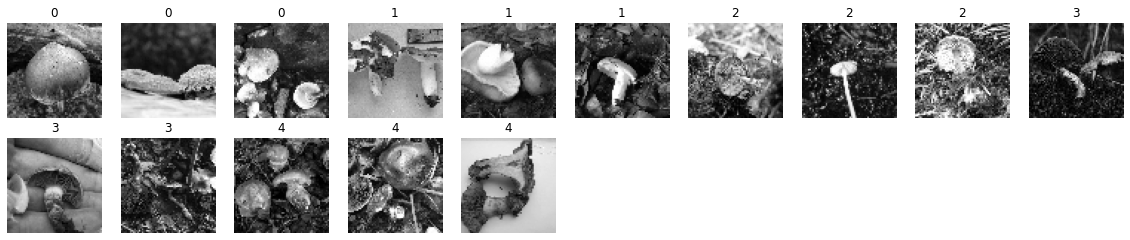

Query 0


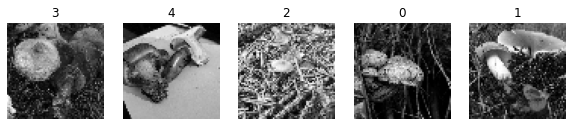

In [57]:
plt.figure(figsize=(20,6));ee=1
batch=0
print(f"Support 0")
for jj in range(WAYS*SHOTS):
    plt.subplot(SHOTS,WAYS*2,ee);plt.imshow(source_x[batch,jj,...,0],"gray")
    plt.title(f"{jj//SHOTS}");plt.axis("off");ee+=1
plt.show()
print("Query 0");plt.figure(figsize=(10,2));ee=1
for jj in range(QUERIES):
    plt.subplot(1,QUERIES,ee);plt.imshow(source_x[batch,WAYS*SHOTS+jj,...,0],"gray")
    plt.title(f"{source_y[batch,jj].numpy().argmax(-1)}");plt.axis("off");ee+=1
plt.show()

In [58]:
for source_x,source_y in data_source:
    break
print(source_x.shape,source_x.numpy().min(),source_x.numpy().max())
print(source_y.shape,source_y.numpy().min(),source_y.numpy().max())
print(source_y.numpy().argmax(-1))

(8, 20, 64, 64, 1) -0.5 0.5
(8, 5, 5) 0.0 1.0
[[2 0 1 3 4]
 [1 3 4 0 2]
 [2 0 1 4 3]
 [4 2 3 1 0]
 [2 0 3 4 1]
 [2 1 0 3 4]
 [0 1 2 4 3]
 [2 1 0 4 3]]


In [59]:
for target_x,target_y in data_target:
    break
print(target_x.shape,target_x.numpy().min(),target_x.numpy().max())
print(target_y.shape,target_y.numpy().min(),target_y.numpy().max())
print(target_y.numpy().argmax(-1))

(8, 20, 64, 64, 1) -0.5 0.5
(8, 5, 5) 0.0 1.0
[[2 0 3 1 4]
 [1 4 2 3 0]
 [0 3 1 4 2]
 [2 4 0 1 3]
 [2 0 4 1 3]
 [4 0 2 3 1]
 [1 4 2 0 3]
 [4 0 1 3 2]]


# 建立模型
按圖索驥，開始組裝network，會有base netwok(for embedding)還有relation network。

* base netwok：由convolution networks組成。

* relation net：用convolution network以及densenet組成，output使用sigmoid讓數值介於0~1之間。

In [60]:
# Embedding function
def F(input_shape):
    convnet = Sequential()
    for i in range(3):
        convnet.add(Conv2D(64,(3,3),padding='valid',input_shape=input_shape))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    return convnet
def build_relation_network(input_shape):
    seq = Sequential()
    #layer1
    seq.add(Conv2D(64, kernel_size=3, F=input_shape,
                           padding="valid",activation='relu'))
    seq.add(BatchNormalization()) 
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
#     seq.add(Dropout(.1))
    
    seq.add(Flatten())
    seq.add(Dense(8, activation='relu'))
#     seq.add(Dropout(0.1))
    seq.add(Dense(1, activation=None))
    return seq

接著組裝network。

這個例子裏面給query用的input再加上每個class的example共有6個，每組訓練資料都要讀取6張圖。

接著將每張圖拿去base_network做成feature maps，

這個network的output與傳統classificaiton一樣，所以也可以使用categorical cross entropy作為loss function。

In [94]:
base_dim = (W,H,CH)
print(base_dim)
base_network = conv_net(base_dim)
# Query feature
x_in=Input(shape=(WAYS*SHOTS+QUERIES,W,H,CH))
latent_s=[base_network(x_in[:,ii]) for ii in range(WAYS*SHOTS)]
latent_q=[base_network(x_in[:,WAYS*SHOTS+ii]) for ii in range(QUERIES)]

relation_net=build_relation_network((latent_q[0].shape[-3],latent_q[0].shape[-2],latent_q[0].shape[-1]*2))
print(latent_q[0].shape[-3],latent_q[0].shape[-2],latent_q[0].shape[-1]*2)
y=[]
for q in latent_q:
    relation_score=[]
    for ww in range(WAYS):
        relation=[relation_net(tf.concat([q,s],-1)) for s in latent_s[ww*SHOTS:(ww+1)*SHOTS]]
        relation_score.append(tf.reduce_mean(tf.concat(relation,-1),-1,keepdims=True))
        
    y.append(tf.nn.softmax(tf.concat(relation_score,-1),-1))
pred=tf.stack(y,1)

model = Model(inputs=x_in, outputs=pred)

(64, 64, 1)
6 6 128


In [62]:
lr=0.001
reduce_lr = cb.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=6, min_lr=1e-8, verbose=1)
tensorboard = cb.TensorBoard(log_dir="tf_relation_logs")
earlystop=cb.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True, verbose=1)
opt = tf.keras.optimizers.Adam(lr=lr)
model.compile(loss=CategoricalCrossentropy(), optimizer=opt, metrics=['acc'])

# 模型訓練
訓練使用10 epoch、batch size為32個tasks，
在訓練時再使用validation split驗證loss是否下降，或者只是over fitting。

In [63]:
EPOCHS=10
# %%time
try:
    model.fit(data_source,
              epochs=EPOCHS, verbose=1,workers=4,
              callbacks=[reduce_lr,earlystop, tensorboard],
              validation_data=data_source)
except KeyboardInterrupt:
    print("KeyboardInterrupt") 

Epoch 1/10
      2/Unknown - 2s 781ms/step - loss: 1.6592 - acc: 0.2375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0680s vs `on_train_batch_end` time: 1.4946s). Check your callbacks.
96/96 [==============================] - 12s 120ms/step - loss: 0.9225 - acc: 0.6841 - val_loss: 0.2732 - val_acc: 0.9674
Epoch 2/10
96/96 [==============================] - 8s 79ms/step - loss: 0.1299 - acc: 0.9799 - val_loss: 0.0348 - val_acc: 0.9956
Epoch 3/10
96/96 [==============================] - 8s 79ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 4/10
96/96 [==============================] - 8s 79ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 6.4136e-04 - val_acc: 1.0000
Epoch 5/10
96/96 [==============================] - 8s 79ms/step - loss: 4.1743e-04 - acc: 1.0000 - val_loss: 4.6734e-04 - val_acc: 1.0000
Epoch 6/10
96/96 [==============================] - 8s 79ms/step - loss: 2.8629e-04 - acc: 1.000

# 預測結果

In [24]:
model.evaluate(data_target, verbose=2)

96/96 - 26s - loss: 2.3295 - acc: 0.3063


[2.3295276165008545, 0.3062500059604645]

In [ ]:
for target_x,target_y in data_target:
    break
print(target_x.shape,target_x.numpy().min(),target_x.numpy().max())
print(target_y.shape,target_y.numpy().min(),target_y.numpy().max())
print(target_y.numpy().argmax(-1))

In [89]:
test_img = "C:/Users/2103099/Documents/kaggle_fungi/target_s/target_s/10994_Basidioradulum_radula/BWP2012PIC66912993.jpg"
# print(target_classes[0])      
# image = cv2.imread(test_img)

img=cv2.imread(test_img.numpy().decode())[...,0].astype(np.float32)/255.
#     img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
min_of_shape = np.min(img.shape[:2])
oh = (img.shape[0] - min_of_shape) // 2
ow = (img.shape[1] - min_of_shape) // 2
center_square = np.array([width,hight])// 2
new_size=(width,hight)

# cropping + resize
img = img[oh:oh + min_of_shape, ow:ow + min_of_shape]
img=np.expand_dims(cv2.resize(img, new_size),-1)


# y_pred = model.predict(np.array(image))
# res = np.argmax(y_pred)
# _ = {"filename": file_name, "ans": res}
# ans = ans.append(_, ignore_index=True)

AttributeError: 'str' object has no attribute 'numpy'

結果在testing set中可以達到不錯的accuracy。

這邊在重點重申一次，這個network並沒有看過testing set的任何一個class，只是學會了5中選一的比較而已。

In [ ]:
# np.random.seed(2021)
# tf.random.set_seed(2021)
# DATA_ROOT="./kaggle_fungi/source"
# # DATA_ROOT=join("..","..","data")
# # DATA_ROOT="I:\AIA Small Data\datasets"
# all_classes = glob(join(DATA_ROOT,"source","*"))
# source_classes,target_classes=train_test_split(all_classes,test_size=0.2)
# sorce_len=len(source_classes)
# target_len=len(target_classes)
# print(f"total {len(all_classes)} classes=source {sorce_len} + target {target_len} classes")

In [29]:
# backup model weights
w = model.get_weights()
print(w)
model.set_weights(w)


[array([[[[-6.72105774e-02,  8.54193494e-02,  2.07733475e-02,
           7.36186504e-02, -1.55054051e-02, -9.04264450e-02,
           1.82025763e-03, -5.65238036e-02,  7.94858485e-02,
          -7.52716586e-02, -5.19144945e-02, -6.48009703e-02,
           6.09328076e-02,  3.65638845e-02,  5.41080870e-02,
          -7.44924545e-02,  6.47714585e-02, -1.28856534e-03,
           3.78380530e-02,  8.94758627e-02, -9.34593007e-02,
          -5.89753129e-02, -8.98831189e-02,  1.41670741e-03,
           1.35013442e-02,  7.00724944e-02, -8.43920186e-02,
           2.97159720e-02, -3.76202576e-02,  4.57527004e-02,
          -1.12787485e-02, -4.33296561e-02, -7.09173679e-02,
          -5.71848229e-02,  3.49659920e-02, -7.87623003e-02,
           1.43324621e-02, -2.14650910e-02, -4.12913561e-02,
           7.30558932e-02,  9.93330255e-02, -7.10138381e-02,
           5.66262491e-02,  1.93918440e-05,  9.13194194e-02,
           6.26844838e-02,  3.06559186e-02, -5.83535023e-02,
          -7.27076009e-

In [103]:
import pandas as pd
# read kaggle test1.csv file row by row
ans = pd.DataFrame(columns=['filename', 'ans'])
import csv
with open (r'C:/Users/2103099/Documents/kaggle_fungi/test2.csv',newline='') as csvfile:
    rows = csv.reader(csvfile)
    print(rows)

    for i, row in enumerate(rows):
#         print(i)
#        
        if i == 0:
            continue
        
        # restore model weights at the begining of adaptation
        model.set_weights(w)

        imgs, labels = (row[0],row[1:4])
        file_name = row[0]
        support_list = row[1:4]
#         print(support_list)
#         C:/Users/2103099/Documents//kaggle_fungi/target_s
        # update weight 10 times

        test_data_path = ["C:/Users/2103099/Documents/kaggle_fungi/target_s/target_s/"+i+"/" for i in support_list]
#         print(test_data_path)
# #         'C:/Users/2103099/Documents//kaggle_fungi/target_s/target_s\\10000_Abortiporus_biennis
        
    
    
#         test_loader = MetaDataLoader2(test_data_path,1, n_way=3, k_shot=5, q_query=0)
#         batch_data = test_loader.get_one_batch()
# #         # train

#         meta_support_image, meta_support_label, meta_query_image, meta_query_label = next(batch_data)
#         model.fit(meta_support_image[0], meta_support_label[0], batch_size=1, epochs=30, validation_split=0.2, verbose=False)
        
        test_img = "C:/Users/2103099/Documents/kaggle_fungi/target_q/target_q/"+file_name
#         print(test_img)
        image = cv2.imread(test_img)
#         print(image)
        image = cv2.resize(image,(64,64),interpolation=cv2.INTER_CUBIC)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.
        image = np.expand_dims(image, axis=-1)
        image = np.array(image)
#         print(np.array(image))
        y_pred = model.predict(image)
#         res = np.argmax(y_pred)
#         _ = {"filename": file_name, "ans": res}
#         ans = ans.append(_, ignore_index=True)
# #         print(ans.tail(1), support_list[res])
# #         print(ans.tail(1))
#         ans_pd =pd.DataFrame(ans)
#         ans_pd.to_csv('SampleSubmission2.csv',index=False)
#         print(ans_pd)

ValueError: in user code:

    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\ProgramData\Anaconda3\envs\AIA_Small_Data\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: [32, 1]


In [32]:
'''Target set中每個人都有一個tf Dataset loader'''
test_sup_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in test_data_path
]
test_q_sub = [
    tf.data.Dataset.list_files(glob(join(sc,'*'+SUFFIX)), shuffle=True)
    .map(map_fun).cache()
    for sc in test_data_path
]

In [33]:
%%time
for sub in test_sup_sub :
    for x in iter(sub.batch(10)):
        pass
for sub in test_q_sub :
    for x in iter(sub.batch(10)):
        pass

Wall time: 390 ms


In [34]:
data_test = tf.data.Dataset.from_generator(partial(gen,test_sup_sub,test_q_sub),
                                    output_types=(tf.float32,tf.float32),
                                    output_shapes=((WAYS*SHOTS+QUERIES,W,H,CH),(QUERIES,WAYS))
                                            ).repeat(MLUT*4).batch(BATCH_SIZE)

In [36]:
for test_x,test_y in data_test:
    break
print(test_x.shape,test_x.numpy().min(),test_x.numpy().max())
print(test_y.shape,test.numpy().min(),test_y.numpy().max())
print(test_y.numpy().argmax(-1))

(8, 20, 64, 64, 1) -0.5 0.5
(8, 5, 5) 0.0 1.0
[[2 0 4 3 1]
 [3 2 0 4 1]
 [0 4 3 1 2]
 [4 2 1 3 0]
 [1 2 0 3 4]
 [2 0 3 1 4]
 [1 2 0 4 3]
 [4 0 2 1 3]]


In [37]:
model.evaluate(data_test, verbose=2)

OverflowError: cannot convert float infinity to integer

# Exercise
請各位使用Relation Net訓練比較Omniglot資料集的兩個字是否相同:

Omniglot資料集：
* source有3856個來自不同語言的不同字符，target有659個不同字符
* 每個class有20張不同人手寫的同一個文字的圖片
* task: source字符選5種不重複
* support: 5字符中從每種20張照片選3張當support
* query: 5字符中再各選1張照片當query(不重複選取，亂序)

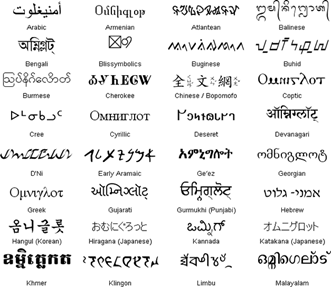

**以下附上圖案讀取的code**

In [24]:
import numpy as np
import cv2

W,H,CH = 64,64,1

def read_image(path, width = W, hight=H):
    img=cv2.imread(path.numpy().decode())[...,0].astype(np.float32)/255.
#     img = read_pgm(path.numpy().decode()).astype(np.float32)/255.
    min_of_shape = np.min(img.shape[:2])
    oh = (img.shape[0] - min_of_shape) // 2
    ow = (img.shape[1] - min_of_shape) // 2
    center_square = np.array([width,hight])// 2
    new_size=(width,hight)
    
    # cropping + resize
    img = img[oh:oh + min_of_shape, ow:ow + min_of_shape]
    img=np.expand_dims(cv2.resize(img, new_size),-1)
    return tf.constant(img-0.5)
SUFFIX='.png'


請自行撰寫data loader以及training內容
e.g.
```
# Data loader
def get_data(...):
    ...
    return X,y

# 建立模型
...
model = Model(x,y)

# 模型訓練
...
model.fit(data_source,......,validation_data=data_source)
```

In [25]:
# Please write your testing code here

# References
[git](https://github.com/sudharsan13296/Hands-On-Meta-Learning-With-Python)

[Paper](https://arxiv.org/abs/1711.06025)